# <mark> **RAG with Azure AI search**

IMPORTANT!! Embeddings Creation - Run this only once !!!
You only need to run this once to create the embeddings and save them to Azure AI Search

We will index a CSV of product names and descriptions

https://github.com/denisa-ms/azure-openai-code-samples/blob/main/RAG%20in%20Azure/RAG%20with%20Azure%20AI%20Search%20CSV/RAG%20-%20Azure%20AI%20Search%20-%20create%20embeddings.ipynb

azure-openai-code-samples/RAG in Azure/RAG with Azure AI Search CSV

In [ ]:
# !pip install -qU openai==1.12.0

In [ ]:
# Import required libraries
import os
import json
from dotenv import load_dotenv

from tenacity import retry, wait_random_exponential, stop_after_attempt
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SimpleField,
    SearchFieldDataType,
    SearchableField,
    SearchField,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    SemanticConfiguration,
    SemanticPrioritizedFields,
    SemanticField,
    SemanticSearch,
    SearchIndex,
    AzureOpenAIVectorizer,
    AzureOpenAIParameters
)
from azure.search.documents.models import VectorizedQuery

from azure.identity import DefaultAzureCredential, get_bearer_token_provider
import json

load_dotenv()

In [ ]:
# Configure environment variables
service_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME")
key = os.getenv("AZURE_SEARCH_ADMIN_KEY")

OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME = os.getenv("OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME")
OPENAI_DEPLOYMENT_ENDPOINT = os.getenv("OPENAI_DEPLOYMENT_ENDPOINT")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
azure_openai_embedding_dimensions = 1536
index_name = "product_data_csv"

In [ ]:
# Configure OpenAI API
aoai_client = AzureOpenAI(
  azure_endpoint = OPENAI_DEPLOYMENT_ENDPOINT,
  api_key=OPENAI_API_KEY,
  api_version="2023-05-15"
)

credential = AzureKeyCredential(key)

**Create Embeddings dataframe**

In [ ]:
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)

In [ ]:
# Generate Document Embeddings using OpenAI Ada Model
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def calc_embeddings(text):
  '''Function to generate embeddings for title and content fields, also used for query embeddings'''
  # model = "deployment_name"
  embeddings = aoai_client.embeddings.create(input = [text], model=OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME).data[0].embedding
  return embeddings

In [ ]:
def do_search(query, fields):
    embedding = calc_embeddings(query)
    vector_query = VectorizedQuery(vector=embedding, k_nearest_neighbors=3, fields=fields)

    results = search_client.search(
        search_text=None,
        vector_queries= [vector_query],
        select=["name", "description"],
    )

    for result in results:
        print(f"Score: {result['@search.score']}")
        print(f"Name: {result['name']}")
        print(f"Description: {result['description']}\n")

In [ ]:
# Pure Vector Search
do_search("nonstick grills", "description_embedding")

# We get non stick grills as the top result and cast iron grills as the second and third result

In [ ]:
# Cross fieldPure Vector Search
do_search("nonstick grills", "name_embedding, description_embedding")

In [ ]:
# Pure Multi-Vector weighted Search
from azure.search.documents.models import VectorizableTextQuery
query = "nonstick grills"

vector_query_1 = VectorizableTextQuery(text=query, k_nearest_neighbors=3, fields="name_embedding", weight=2)
vector_query_2 = VectorizableTextQuery(text=query, k_nearest_neighbors=3, fields="description_embedding", weight=0.5)

results = search_client.search(
    search_text=None,
    vector_queries=[vector_query_1, vector_query_2],
    select=["name", "description"],
)

for result in results:
    print(f"Score: {result['@search.score']}")
    print(f"Name: {result['name']}")
    print(f"Description: {result['description']}\n")

In [ ]:
# Read the CSV file and generate embeddings for title and description fields
import pandas as pd

# Read the CSV file
product_data = pd.read_csv("./data/Product Dataset.csv",encoding = "ISO-8859-1")
product_data.name.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
product_data.description.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

product_data.head()

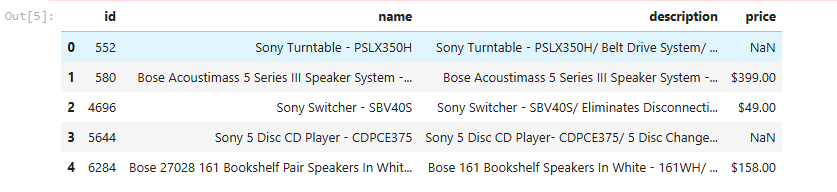

In [ ]:
import uuid

product_data["name_embedding"] = product_data.name.apply(lambda x: calc_embeddings(x))
product_data["description_embedding"] = product_data.description.apply(lambda x: calc_embeddings(x))

product_data.to_csv('./data/prd_data_with_embeddings.csv', index=False)
print(product_data.head(2))

In [ ]:
#convert the id column to string
product_data['id'] = product_data['id'].apply(str)
# Drop the price column
product_data = product_data.drop('price', axis=1)

# Output embeddings to products.json file
output_path = os.path.join('.', 'data', 'prd_data_with_embeddings.json')

with open(output_path, 'w') as f:
    product_data.to_json(f, orient='records')

**Create Search Index**

    index_client
    fields
    vector_search
    semantic_config
    semantic_search


In [ ]:
# Create a search index
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="name", type=SearchFieldDataType.String),
    SearchableField(name="description", type=SearchFieldDataType.String),
    SearchField(name="name_embedding", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_profile_name="myHnswProfile"),
    SearchField(name="description_embedding", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_profile_name="myHnswProfile"),
]

In [ ]:
# Configure the vector search configuration
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(
            name="myHnsw"
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswProfile",
            algorithm_configuration_name="myHnsw",
            vectorizer="myVectorizer"
        )
    ],
    vectorizers=[
        AzureOpenAIVectorizer(
            name="myVectorizer",
            azure_open_ai_parameters=AzureOpenAIParameters(
                resource_uri=OPENAI_DEPLOYMENT_ENDPOINT,
                deployment_id=OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME,
                model_name=OPENAI_ADA_EMBEDDING_DEPLOYMENT_NAME,
                api_key=OPENAI_API_KEY
            )
        )
    ]
)

In [ ]:
semantic_config = SemanticConfiguration(
    name="my-semantic-config",
    prioritized_fields=SemanticPrioritizedFields(
        title_field=SemanticField(field_name="name"),
        content_fields=[SemanticField(field_name="description")]
    )
)
# Create the semantic settings with the configuration
semantic_search = SemanticSearch(configurations=[semantic_config])

In [ ]:
# Create the search index with the semantic settings
index = SearchIndex(
    name=index_name,
    fields=fields,
    vector_search=vector_search,
    semantic_search=semantic_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

**Upload documents to search index**

In [ ]:
from azure.search.documents import SearchClient
import json

# Upload some documents to the index
output_path = os.path.join('.', 'data', 'prd_data_with_embeddings.json')
with open(output_path, 'r') as file:
    documents = json.load(file)
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
result = search_client.upload_documents(documents)
print(f"Uploaded {len(documents)} documents")

In [ ]:
## If you are indexing a very large number of documents, you can use the SearchIndexingBufferedSender which is an optimized way to automatically index the docs as it will handle the batching for you
from azure.search.documents import SearchIndexingBufferedSender

# Upload some documents to the index
output_path = os.path.join('.', 'data', 'prd_data_with_embeddings.json')
with open(output_path, 'r') as file:
    documents = json.load(file)

# Use SearchIndexingBufferedSender to upload the documents in batches optimized for indexing
with SearchIndexingBufferedSender(
    endpoint=service_endpoint,
    index_name=index_name,
    credential=credential,
) as batch_client:
    # Add upload actions for all documents
    batch_client.upload_documents(documents=documents)
print(f"Uploaded {len(documents)} documents in total")

# <mark> **SemanticSearch vs VectorSearch**


https://medium.com/@simeon.emanuilov/semantic-vs-vector-search-7f4e86b07c95#:~:text=Semantic%20search%3A%20Focuses%20on%20understanding,mathematical%20representations%20and%20similarity%20calculations.



**Semantic search** first reads the meaning and intent of your query. Vector Search then represents both your query and possible results as vectors and identifies the best matches.

Semantic search is an advanced information retrieval method that focuses on understanding the intent and contextual meaning of a search query, rather than just matching keywords. It employs natural language processing (NLP) and machine learning techniques to interpret the nuances, synonyms, and relationships inherent in language.

**How semantic search works:- **

1. Query analysis: The search engine interprets the user’s query, considering context, intent, and potential ambiguities.
2. Concept extraction: Key concepts and entities are identified from the query.
3. Knowledge graph consultation: The system consults its knowledge graph to understand relationships between concepts.
4. Context-aware matching: Instead of exact keyword matching, the system looks for content that matches the query’s intent and context.
5. Result ranking: Results are ranked based on relevance to the query’s semantic meaning.

The technology behind semantic search

Semantic search leverages several advanced technologies to understand and process natural language:

1. Natural Language Processing (NLP): NLP techniques help in parsing and understanding the structure and meaning of text.
2. Machine Learning (ML): ML algorithms learn from vast amounts of data to improve their understanding of language and context over time.
3. Knowledge graphs: These represent relationships between concepts, entities, and data points, allowing for more contextual understanding.
4. Inference engines: These systems use logical rules to derive new information from existing knowledge.

Traditional search mechanisms often operate on the principle of keyword matching, which can sometimes lead to a disconnect between the results returned and the user's actual intent.

For instance, consider a user searching for the term “apple.” A traditional search engine might return results related to the fruit, the technology company, or even content associated with the city of New York (“The Big Apple”). The search engine cannot deliver the most relevant results without understanding the context or specific intent behind the user’s query.

Why we need to care about semantic search: By leveraging NLP and ML, semantic search can ascertain that a user looking for “apple” alongside words like “iPhone” or “MacBook” is likely interested in technology rather than horticulture. Therefore, it adjusts the search results accordingly, substantially improving accuracy and relevance.

The operational backbone of semantic search lies in creating and analyzing data embeddings and vectors. When a query is issued, the search engine employs NLP to transform the words into numerical representations, known as embeddings, that capture the words and the context and nuances surrounding them.

These embeddings are then mapped into vectors, essentially multi-dimensional spaces where similar meanings are positioned close to each other.

Through algorithms like k-nearest neighbor (kNN), the search engine can then sift through these vectors to identify and rank documents (or web pages) that are semantically related to the query. This process enables the search engine to surface conceptually related content, even if it doesn’t contain exact match keywords.

**Vector search**, on the other hand, is a technique that transforms words, sentences, or entire documents into vectors — numerical representations in a multidimensional space. These vectors capture the essence of the content, allowing for similarity comparisons based on their positions in this vector space. Vector search is at the heart of many modern search systems, including those that power semantic search. At the core of vector search are vector embeddings. These are numerical representations of words, phrases, or documents in a high-dimensional space.

Vector embeddings are typically created using machine learning models trained on large corpora of text. Popular models include:

1. Word2Vec
2. GloVe
3. BERT
4. GPT

These models learn to represent words or pieces of text in a way that captures semantic relationships. For instance, in a well-trained model, the vectors for “king” and “queen” might be close to each other, reflecting their semantic similarity.

Similarity measures
Once we have vector representations, we need ways to measure how similar they are.

1. Cosine similarity
2. Euclidean distance
3. Dot product

**Vector search process**

1. Indexing: Documents or items are converted into vector embeddings and stored in a database.
2. Query vectorization: The search query is converted into a vector using the same embedding model.
3. Similarity calculation: The system calculates the similarity between the query vector and all (or a subset of) document vectors.
4. Ranking: Results are ranked based on their similarity scores.

**Semantic search vs Vector search: Key differences**

While semantic search and vector search are related and often used together, they have some key differences:

Approach to understanding:

Semantic search: Focuses on understanding the meaning and intent behind queries and content.
Vector search: Relies on mathematical representations and similarity calculations.
Contextual understanding:

Semantic search: Can handle complex queries and understand context beyond individual words.
Vector search: Primarily relies on learned representations, which may or may not capture all contextual nuances.
Knowledge representation:

Semantic search: Often uses knowledge graphs and ontologies to represent relationships.
Vector search: Represents knowledge as points in a high-dimensional space.
Query processing:

Semantic search: May involve complex NLP pipelines to understand query intent.
Vector search: Typically involves converting the query to a vector and performing similarity calculations.
Scalability:

Semantic search: Can be computationally intensive, especially with large knowledge graphs.
Vector search: Often more scalable, with efficient indexing techniques for large datasets.